# Content

1. Read in <strike>two</strike> one file<strike>s</strike> per read_csv() separately
1. <strike>Merge two datasources /for lines of code(?) -> would be optional</strike>
1. Calculate ownership

In [61]:
import glob
import pandas as pd

#file_list = glob.glob("../../buschmais-spring-petclinic/src/**/*.java", recursive=True)
file_list = glob.glob("../../linux/**/*.c", recursive=True)
file_list[0:10]

['../../linux\\arch\\alpha\\boot\\bootp.c',
 '../../linux\\arch\\alpha\\boot\\bootpz.c',
 '../../linux\\arch\\alpha\\boot\\main.c',
 '../../linux\\arch\\alpha\\boot\\misc.c',
 '../../linux\\arch\\alpha\\boot\\stdio.c',
 '../../linux\\arch\\alpha\\boot\\tools\\mkbb.c',
 '../../linux\\arch\\alpha\\boot\\tools\\objstrip.c',
 '../../linux\\arch\\alpha\\kernel\\asm-offsets.c',
 '../../linux\\arch\\alpha\\kernel\\audit.c',
 '../../linux\\arch\\alpha\\kernel\\binfmt_loader.c']

In [63]:
dfs = []

for filepath in file_list:
    
    df = pd.read_csv(filepath,
                     sep="\u0012",
                     names=['line'],
                     encoding='latin-1')
    
    df['filepath'] = filepath
    dfs.append(df)

source_code = pd.concat(dfs, ignore_index=True)
source_code.head()

,line,filepath
0,/*,../../linux\arch\alpha\boot\bootp.c
1,* arch/alpha/boot/bootp.c,../../linux\arch\alpha\boot\bootp.c
2,*,../../linux\arch\alpha\boot\bootp.c
3,* Copyright (C) 1997 Jay Estabrook,../../linux\arch\alpha\boot\bootp.c
4,*,../../linux\arch\alpha\boot\bootp.c


In [70]:
source_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14761327 entries, 0 to 14761326
Data columns (total 2 columns):
line        object
filepath    object
dtypes: object(2)
memory usage: 225.2+ MB


In [71]:
source_code['indent_ws'] = source_code.line.str.extract("^( *).*", expand=True)[0].str.len()
source_code.head()

,line,filepath,indent_ws
0,/*,../../linux\arch\alpha\boot\bootp.c,0
1,* arch/alpha/boot/bootp.c,../../linux\arch\alpha\boot\bootp.c,1
2,*,../../linux\arch\alpha\boot\bootp.c,1
3,* Copyright (C) 1997 Jay Estabrook,../../linux\arch\alpha\boot\bootp.c,1
4,*,../../linux\arch\alpha\boot\bootp.c,1


In [85]:
source_code['indent_tab'] = source_code.line.str.extract("^(\t*).*", expand=True)[0].str.len()
source_code.head()

,line,filepath,indent_ws,indent_tab
0,/*,../../linux\arch\alpha\boot\bootp.c,0,0
1,* arch/alpha/boot/bootp.c,../../linux\arch\alpha\boot\bootp.c,1,0
2,*,../../linux\arch\alpha\boot\bootp.c,1,0
3,* Copyright (C) 1997 Jay Estabrook,../../linux\arch\alpha\boot\bootp.c,1,0
4,*,../../linux\arch\alpha\boot\bootp.c,1,0


In [87]:
source_code['indent'] = source_code.indent_ws + source_code.indent_tab * 4
source_code.head()

,line,filepath,indent_ws,indent_tab,indent
0,/*,../../linux\arch\alpha\boot\bootp.c,0,0,0
1,* arch/alpha/boot/bootp.c,../../linux\arch\alpha\boot\bootp.c,1,0,1
2,*,../../linux\arch\alpha\boot\bootp.c,1,0,1
3,* Copyright (C) 1997 Jay Estabrook,../../linux\arch\alpha\boot\bootp.c,1,0,1
4,*,../../linux\arch\alpha\boot\bootp.c,1,0,1


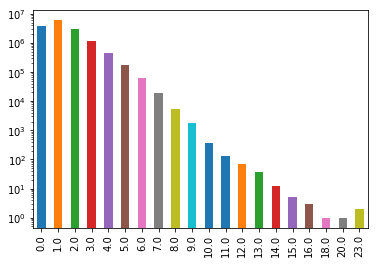

In [98]:
%matplotlib inline
import numpy as np

np.floor(source_code.indent / 4).value_counts().sort_index().plot.bar(logy=True)

In [104]:
line_count = source_code.groupby('filepath').line.count()
indent_sum = source_code.groupby('filepath').indent.sum()
result = pd.DataFrame([line_count,indent_sum]).T
result.head()

,line,indent
filepath,,
../../linux\Documentation\scheduler\sched-pelt.c,85,347
../../linux\Documentation\usb\usbdevfs-drop-permissions.c,103,496
../../linux\arch\alpha\boot\bootp.c,183,543
../../linux\arch\alpha\boot\bootpz.c,399,1464
../../linux\arch\alpha\boot\main.c,164,509


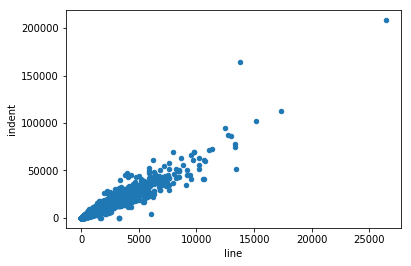

In [109]:
result.plot.scatter('line', 'indent')

In [112]:
result.sort_values(by='line', ascending=False).head()

,line,indent
filepath,,
../../linux\drivers\net\wireless\broadcom\brcm80211\brcmsmac\phy\phy_n.c,26395,208274
../../linux\drivers\scsi\lpfc\lpfc_sli.c,17302,112467
../../linux\drivers\net\ethernet\broadcom\tg3.c,15172,101662
../../linux\drivers\isdn\hardware\eicon\message.c,13777,164679
../../linux\fs\nls\nls_cp949.c,13391,51367


In [113]:
result['complexity'] = result.indent / result.line
result = result.sort_values(by='complexity', ascending=False)
result.head(10)

,line,indent,complexity
filepath,,,
../../linux\drivers\net\ethernet\dec\tulip\interrupt.c,693,9342,13.480519
../../linux\drivers\pci\hotplug\ibmphp_res.c,1960,25853,13.190306
../../linux\scripts\kconfig\lxdialog\inputbox.c,273,3495,12.802198
../../linux\net\9p\protocol.c,567,7173,12.650794
../../linux\drivers\staging\rtl8723bs\hal\HalPwrSeqCmd.c,180,2249,12.494444
../../linux\drivers\media\pci\ttpci\av7110_ipack.c,360,4496,12.488889
../../linux\drivers\misc\altera-stapl\altera.c,2231,27839,12.478261
../../linux\drivers\scsi\gdth_proc.c,580,6998,12.065517
../../linux\drivers\isdn\hardware\eicon\message.c,13777,164679,11.953183


In [52]:
source_code.indent_tab.value_counts()

0    3384
1       4
2       1
Name: indent_tab, dtype: int64

In [1]:
            
        
    
            

        
            
for filename in file_list:
    lines = 0
    indent = 0
    with open(filename) as f:
        for line in f.readlines():
            line = line.replace("\t", " ")
            # BUG: Just count first whitespaces, not all in line
            indent = indent + line.count(" ")
            lines = lines + 1
    lines_of_code.append([filename, lines, indent])
    
lines_df = pd.DataFrame(lines_of_code, columns=["file", "lines", "indent"])
lines_df['file'] = lines_df.file.str.replace("\\", "/").str.replace("../../../buschmais-spring-petclinic/", "")
lines_df = lines_df.sort_values(by="lines", ascending=False)
lines_df['file'] = lines_df.file.str.replace("org/springframework/samples/", "")

lines_df.head()

,file,lines,indent


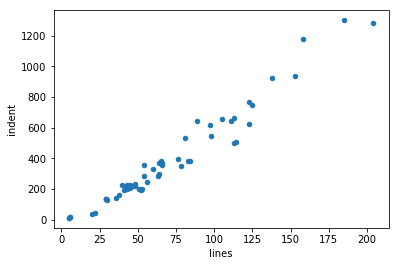

In [5]:
%matplotlib inline
lines_df.plot.scatter('lines', 'indent')

In [6]:
changes.head()

,author,filename,additions,deletions
0,Antoine Rey,src/test/java/petclinic/web/CrashControllerTes...,4.0,5.0
1,Antoine Rey,src/test/java/petclinic/web/OwnerControllerTes...,25.0,7.0
2,Antoine Rey,src/test/java/petclinic/web/PetControllerTests...,21.0,9.0
3,Antoine Rey,src/test/java/petclinic/web/VetControllerTests...,23.0,3.0
4,Antoine Rey,src/test/java/petclinic/web/VisitControllerTes...,10.0,6.0


In [7]:
changes['lines'] = changes.additions - changes.deletions
changes.groupby("filename").sum().sort_values(by='lines', ascending=False).head()

,additions,deletions,lines
filename,,,
src/test/java/petclinic/service/AbstractClinicServiceTests.java,388.0,184.0,204.0
src/test/java/petclinic/web/OwnerControllerTests.java,192.0,7.0,185.0
src/main/java/petclinic/repository/jdbc/JdbcOwnerRepositoryImpl.java,388.0,230.0,158.0
src/main/java/petclinic/model/Owner.java,290.0,137.0,153.0
src/main/java/petclinic/web/OwnerController.java,311.0,173.0,138.0


In [8]:
result = pd.merge(lines_df, changes, left_on='file', right_on="filename")
result.head()

,file,lines_x,indent,author,filename,additions,deletions,lines_y
0,src/test/java/petclinic/service/AbstractClinic...,204,1283,Attilio,src/test/java/petclinic/service/AbstractClinic...,10.0,0.0,10.0
1,src/test/java/petclinic/service/AbstractClinic...,204,1283,Faisal Hameed,src/test/java/petclinic/service/AbstractClinic...,1.0,1.0,0.0
2,src/test/java/petclinic/service/AbstractClinic...,204,1283,Antoine Rey,src/test/java/petclinic/service/AbstractClinic...,2.0,1.0,1.0
3,src/test/java/petclinic/service/AbstractClinic...,204,1283,Antoine Rey,src/test/java/petclinic/service/AbstractClinic...,86.0,86.0,0.0
4,src/test/java/petclinic/service/AbstractClinic...,204,1283,Antoine Rey,src/test/java/petclinic/service/AbstractClinic...,2.0,0.0,2.0


In [13]:
def aggregate_additions(group):
    df = group.groupby(['author'])[['additions']].count()
    df['all_additions'] = group['additions'].count()
    df['ownership'] = df['additions'] / df['all_additions']
    return df

ownerships = changes.groupby('filename').apply(aggregate_additions)
ownerships.groupby('filename')[['ownership']].max()

,ownership
filename,
org.springframework.samples.petclinic/src/main/java/petclinic/HomeController.java,0.750000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/Appointment.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/AppointmentBook.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/AppointmentForm.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/Appointments.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/AppointmentsController.java,0.666667
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/StubAppointmentBook.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/owner/Owner.java,1.000000
org.springframework.samples.petclinic/src/main/java/petclinic/owner/OwnerController.java,1.000000


In [19]:
ownerships.loc["org.springframework.samples.petclinic/src/main/java/petclinic/pet/PetRepository.java"]

,additions,all_additions,ownership
author,,,
Keith Donald,2,2,1.0


In [16]:
ownerships.loc["org.springframework.samples.petclinic/src/main/java/petclinic/owner/OwnerController.java"]

,additions,all_additions,ownership
author,,,
Keith Donald,2,2,1.0


In [9]:
def aggregate_additions(group):
    df = group.groupby(['author'])[['additions']].sum()
    df['all_additions'] = group['additions'].sum()
    df['ownership'] = df['additions'] / df['all_additions']
    return df

changes.groupby('filename').apply(aggregate_additions)

additions  \
filename                                           author                      
org.springframework.samples.petclinic/src/main/... Keith Donald         17.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         37.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         13.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         67.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         15.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         44.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         23.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         26.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         36.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         13.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         45.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         21.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         78.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         45.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         14.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         15.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         50.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         24.0   
...                                                                      ...   
src/test/java/petclinic/service/ClinicServiceJd... Michael Isvy         37.0   
src/test/java/petclinic/service/ClinicServiceJp... Antoine Rey           3.0   
                                                   Michael Isvy         30.0   
src/test/java/petclinic/service/ClinicServiceSp... Antoine Rey           4.0   
                                                   Michael Isvy         20.0   
src/test/java/petclinic/springdatajpa/JpaOwnerR... Michael Isvy         36.0   
src/test/java/petclinic/springdatajpa/JpaPetRep... Michael Isvy         30.0   
src/test/java/petclinic/springdatajpa/JpaVetRep... Michael Isvy         30.0   
src/test/java/petclinic/springdatajpa/JpaVisitR... Michael Isvy         30.0   
src/test/java/petclinic/springdatajpa/SpringDat... Michael Isvy         21.0   
src/test/java/petclinic/web/CrashControllerTest... Antoine Rey           4.0   
                                                   Colin But            53.0   
src/test/java/petclinic/web/OwnerControllerTest... Antoine Rey          25.0   
                                                   Colin But           167.0   
src/test/java/petclinic/web/PetControllerTests.... Antoine Rey          21.0   
                                                   Colin But           113.0   
src/test/java/petclinic/web/PetTypeFormatterTes... Colin But            76.0   
src/test/java/petclinic/web/VetControllerTest.java Michael Isvy    

Wegen Datenschutz reicht es ja, nur die "Stärke" der Wissenskonzentration zu visualisieren